## Import modules

In [3]:
import os
import sys
import math
from collections import OrderedDict
import copy
import random
import glob
from easydict import EasyDict
from typing import Dict, List
import time
os.chdir('/home/yuanyu/projects/rush')

import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.nn.init as init
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from skimage import exposure, img_as_float

from models.MNAD.model.utils import CustomDataLoader
from models.MNAD.model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1 import *
from models.MNAD.model.Reconstruction import *
from models.MNAD.utils import *
import urls

## 1 Set configs and environment

In [2]:
cfg = EasyDict(
    # dataset
    video_folder='/home/yuanyu/projects/data/DaYanTa_2/8_C51/frames',
    label_file_path='/home/yuanyu/projects/dyt_VAD/label2.csv',
    transform=transforms.Compose([transforms.ToTensor()]),
    resized_height=256,
    resized_width=256,
    time_step=4,
    num_pred=1,

    # model
    method='pred',
    t_length=5,
    fdim=512,
    mdim=512,
    msize=10,

    # test
    # label_df_path='/home/yuanyu/projects/dyt_VAD/label.csv'
    model_path='./models/MNAD/exp/Xian/pred/log/model.pth',
    m_items_path='./models/MNAD/exp/Xian/pred/log/keys.pt',
    log_dir='./xian_results2',
    gpus='1,2,3',
    batch_size=1,
    num_workers=1,

    alpha=1,
    th=0.01,
    loss_func_mse=nn.MSELoss(reduction='none'),
)

if not os.path.exists(cfg.log_dir):
    os.mkdir(cfg.log_dir)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpus
# make sure to use cudnn for computational performance
torch.backends.cudnn.enabled = True

## 2 Load the dataset and model

In [4]:
# init dataloader
test_dataset = CustomDataLoader(cfg.video_folder, transforms.Compose([
    transforms.ToTensor(),
]), label_file_path=cfg.label_file_path,
    resize_height=cfg.resized_height, resize_width=cfg.resized_width, time_step=cfg.t_length-1, train=False)

test_loader = data.DataLoader(test_dataset, batch_size=cfg.batch_size,
                             shuffle=False, num_workers=cfg.num_workers, drop_last=False)

In [5]:
# init model
model = torch.load(cfg.model_path)
model.cuda()
model.eval()
m_items = torch.load(cfg.m_items_path)


In [6]:
# log and test data_loader
print(len(test_loader))
for data in test_loader:
    print(type(data), data.shape)
    break

50470
<class 'torch.Tensor'> torch.Size([1, 15, 256, 256])


In [7]:
# log and test model
for imgs in test_loader:
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    
    print(mse_loss)
    break

0.0002308917319169268


## 3 Run the model on dataloader, and save results

In [8]:
# Init result savers
results = dict()

video_name_list = list()

mse_imgs_list = list()
mse_loss_list = list()
psnr_list = list()

In [9]:
for i, imgs in enumerate(test_loader):
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    psnr_ = psnr(mse_loss)

    print(i, mse_loss)
    torch.save({
        'mse_imgs': mse_imgs,
        'mse_loss': mse_loss,
        'psnr': psnr_
    }, f'{cfg.log_dir}/result_{i}.pt')

25160564109683037
49768 0.0002718433679547161
49769 0.0002519014524295926
49770 0.00028599740471690893
49771 0.00023471277381759137
49772 0.00027478893753141165
49773 0.000244456110522151
49774 0.00027551522362045944
49775 0.00024294434115290642
49776 0.000694942835252732
49777 0.00037774801603518426
49778 0.00028278405079618096
49779 0.0002830572775565088
49780 0.0002883071720134467
49781 0.0003390322090126574
49782 0.0003126451629213989
49783 0.0002482373674865812
49784 0.00028840693994425237
49785 0.00024540995946154
49786 0.0002548892516642809
49787 0.00023941253311932087
49788 0.0002580140717327595
49789 0.00029336026636883616
49790 0.00025627436116337776
49791 0.0002479466493241489
49792 0.00022806922788731754
49793 0.0002202727773692459
49794 0.00021222667419351637
49795 0.00022417667787522078
49796 0.0002560761640779674
49797 0.0002478004898875952
49798 0.00025998434284701943
49799 0.0002458572562318295
49800 0.00027123361360281706
49801 0.0007405709475278854
49802 0.0003617058

## 4 match results with video_name

In [10]:
samples = test_dataset.samples
print(len(samples), samples[0])
# print(samples)

50470 /home/yuanyu/projects/data/DaYanTa_2/8_C51/frames/2021-04-29_20-42-26_024/img_00001.jpg


In [11]:
result_dict = dict()

for i, frame_path in enumerate(samples):
    video_name = frame_path.split('/')[-2]
    frame_name = frame_path.split('/')[-1].split('.')[-2]

    if result_dict.get(video_name, None) is None:
        result_dict[video_name] = list()
    result_dict[video_name].append(
        (frame_path, i)
    )

torch.save(result_dict, f'{cfg.log_dir}/result_dict.pt')

## 5 Evaluate results

In [12]:
result_dict = torch.load(f'{cfg.log_dir}/result_dict.pt')
# print(result_dict)
label_df = pd.read_csv(cfg.label_file_path, index_col=3)


In [13]:
label_df.head()

,Unnamed: 0,district,date,start_frame,end_frame,anomaly
new_video,,,,,,
2021-04-29_20-42-26_024,0,厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_025,1,厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_026,2,厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_027,3,厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_028,4,厅中付费区51,429,-1,-1,推婴儿车


In [14]:
# label_df
print(len(label_df))
print(len(result_dict))
# print(label_df.index)
count = 0
for video_name in label_df.index:
    if video_name not in result_dict.keys():
        count+=1
        print(video_name)
print(count)

238
206
2021-04-29_22-32-35_8638
2021-04-29_22-32-35_8639
2021-04-29_22-32-35_8638
2021-04-29_22-32-35_8639
4


In [15]:
def show_one_result(result_dict: Dict[str, object], samples: List[str], idx: int):
    assert idx < len(samples)
    frame_path = samples[idx]
    video_name = frame_path.split('/')[-2]
    anomaly = label_df.loc[video_name, 'anomaly']
    print(video_name, anomaly)

    result = result_dict[video_name]

    psnr_list = list()
    mse_imgs = list()
    # anomaly_score_list_ = list()
    for _, i in result:
        # print(frame_path, i)
        
        # load raw frame

        # load mse_imgs, psnr
        result_i = torch.load(f'{cfg.log_dir}/result_{i}.pt')
        mse_img = result_i['mse_imgs'].permute(1, 2, 0).cpu().detach().numpy()
        psnr = result_i['psnr']

        mse_imgs.append(mse_img)
        psnr_list.append(psnr)
        # break
    # print(psnr_list)
    anomaly_score_list_ = anomaly_score_list(psnr_list)
    fig = plt.figure()
    ims = []
    for i in range(len(anomaly_score_list_)):
        im = plt.plot(anomaly_score_list_[:i])
        plt.yticks(np.arange(0, 1.1, 0.1))
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(f"score_{video_name}.gif",writer='pillow')

    fig = plt.figure()
    plt.axis('off')
    ims = []
    for i in range(len(mse_imgs)):
        img = mse_imgs[i]
        img = 1 - exposure.rescale_intensity(img)
        im = plt.imshow(img, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(f"mse_{video_name}.gif",writer='pillow')
    # plt.show()
    # print(anomaly_score_list_)
    

2021-04-29_20-42-26_035 推婴儿车


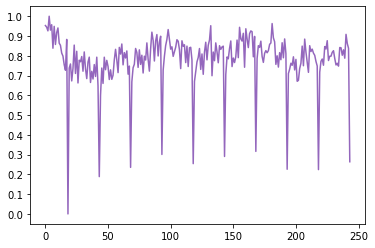

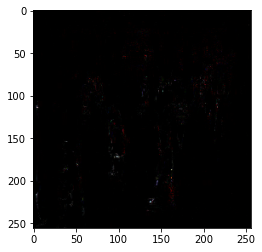

In [16]:
# for i in range(10):
show_one_result(result_dict, samples, 2000)
    # input()
    # break